# Machine Learning (COSC 522)
## Project 4

In [ ]:
# Import Jupyter Widgets
import os
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
# Clone the repository if you're in Google Collab
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)
def mount_and_change_dir(is_collab: bool = False):
    # Set working directory
    project_path = '/content/drive/MyDrive/Projects/UTK/COSC522'
    os.chdir(project_path)
    print(os.listdir(project_path))
       
print("Are you on Google Collab?")
btn = widgets.Button(description="Yes")
btn.on_click(mount_and_change_dir)
display(btn)

Are you on Google Collab?


Button(description='Yes', style=ButtonStyle())

['Project4.ipynb', 'LICENSE', 'Makefile', '.gitignore', 'Project1.ipynb', 'Project2.ipynb', 'Project3.ipynb', 'TODO.md', 'custom_libs', 'requirements.txt', 'data', 'setup.py', 'README.md']


## Import libraries

In [ ]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_formats = ['png']

import numpy as np
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns
from scipy.stats import uniform, gaussian_kde, norm
from typing import *
from tqdm.notebook import tqdm

from custom_libs import ColorizedLogger

sns.set_style('darkgrid')

logger = ColorizedLogger('Project4', 'yellow')

### Import custom classes

In [ ]:
# Located in <project root>/custom_libs/Project4
import custom_libs.Project4.models as p4_models
import custom_libs.Project4.data_loader as dl
import custom_libs.Project4.plotter as pl

### Load the two datasets and Preprocess them

In [ ]:
# Create a Data Loader
datasets = ['xor', 'mnist']
data_loader = dl.DataLoader(datasets=datasets, data_folder='data')

In [ ]:
# Get the two datasets
datasets = data_loader.get_datasets()
xor_data = datasets['xor']
mnist_tr, mnist_te, mnist_val = datasets['mnist']
# Print their statistics
data_loader._print_statistics(mnist_tr, 'mnist_tr')
data_loader._print_statistics(mnist_te, 'mnist_te')
data_loader._print_statistics(mnist_val, 'mnist_val')
data_loader._print_statistics(xor_data, 'xor_data')

2021-10-30 22:36:36 Data Loader  INFO     -- mnist_tr --
2021-10-30 22:36:36 Data Loader  INFO     	Shape: (50000, 785)
2021-10-30 22:36:36 Data Loader  INFO     	Type: float64
2021-10-30 22:36:36 Data Loader  INFO     	Mean:
2021-10-30 22:36:36 Data Loader  INFO     		[0. 0. 0. 0.] (..)
2021-10-30 22:36:36 Data Loader  INFO     	Max:
2021-10-30 22:36:36 Data Loader  INFO     		[0. 0. 0. 0.] (..)
2021-10-30 22:36:36 Data Loader  INFO     	Min:
2021-10-30 22:36:36 Data Loader  INFO     		[0. 0. 0. 0.] (..)
2021-10-30 22:36:36 Data Loader  INFO     	Head:
2021-10-30 22:36:36 Data Loader  INFO     		[0. 0. 0. 0.] (..)
2021-10-30 22:36:36 Data Loader  INFO     -- mnist_te --
2021-10-30 22:36:36 Data Loader  INFO     	Shape: (10000, 785)
2021-10-30 22:36:36 Data Loader  INFO     	Type: float64
2021-10-30 22:36:36 Data Loader  INFO     	Mean:
2021-10-30 22:36:36 Data Loader  INFO     		[0. 0. 0. 0.] (..)
2021-10-30 22:36:36 Data Loader  INFO     	Max:
2021-10-30 22:36:36 Data Loader  INFO   

#### Normalize and standarize the datasets

In [ ]:
# xor
xor_data_norm = data_loader.normalize_(xor_data)[0]
xor_data_stand = data_loader.standarize_(xor_data)[0]
logger.info(f"xor_data_norm\n {xor_data_norm}")
logger.info(f"xor_data_stand\n {xor_data_stand}")
# mnist
mnist_tr_norm, mnist_te_norm, mnist_val_norm = data_loader.normalize_(mnist_tr, 
                                                                      mnist_te,
                                                                      mnist_val)
mnist_tr_stand, mnist_te_stand, mnist_val_stand = data_loader.standarize_(mnist_tr, 
                                                                          mnist_te,
                                                                          mnist_val)
logger.info("mnist_tr, mnist_te, mnist_val Normalized")
logger.info("mnist_tr, mnist_te, mnist_val Standarized")

2021-10-30 22:36:37 Project4     INFO     xor_data_norm
 [[-0.5 -0.5  0. ]
 [-0.5  0.5  1. ]
 [ 0.5 -0.5  1. ]
 [ 0.5  0.5  0. ]]
2021-10-30 22:36:37 Project4     INFO     xor_data_stand
 [[-1. -1.  0.]
 [-1.  1.  1.]
 [ 1. -1.  1.]
 [ 1.  1.  0.]]
2021-10-30 22:36:38 Project4     INFO     mnist_tr, mnist_te, mnist_val Normalized
2021-10-30 22:36:38 Project4     INFO     mnist_tr, mnist_te, mnist_val Standarized


#### One Hot Encode the target vectors of XOR, Mnist Train, Mnist Test, Mnist Validation

In [ ]:
# One Hot Encode the target values
# xor
xor_y_one_hot = data_loader.one_hot_encode_last(xor_data)
logger.info(f"XOR Y one hot encoded\n {xor_y_one_hot}")
# Mnist
mnist_tr_y_one_hot = data_loader.one_hot_encode_last(mnist_tr)
logger.info(f"mnist_tr Y one hot encoded\n {mnist_tr_y_one_hot}")
mnist_te_y_one_hot = data_loader.one_hot_encode_last(mnist_te)
logger.info(f"mnist_te Y one hot encoded\n {mnist_te_y_one_hot}")
mnist_val_y_one_hot = data_loader.one_hot_encode_last(mnist_val)
logger.info(f"mnist_val Y one hot encoded\n {mnist_val_y_one_hot}")

2021-10-30 22:36:38 Project4     INFO     XOR Y one hot encoded
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]
2021-10-30 22:36:38 Project4     INFO     mnist_tr Y one hot encoded
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
2021-10-30 22:36:38 Project4     INFO     mnist_te Y one hot encoded
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
2021-10-30 22:36:38 Project4     INFO     mnist_val Y one hot encoded
 [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Function that trains the Model  for the desired hyperparameters

In [ ]:
def train_dataset(dataset, targets, hidden_layers, activations, loss_functions, lr, momentum,
                   batch_size, early_stopping, max_epochs, regularization_param, shuffle, 
                   symmetric_weights, seed, debug):
    # Number of units per layer
    n_units = [int(dataset.shape[1]-1), *hidden_layers, int(dataset[:, -1].max()+1)]
    # Initialize Model
    mlp = p4_models.MultiLayerPerceptron(units=n_units, activations=activations, 
                                         symmetric_weights=symmetric_weights,
                                         loss_functions=loss_functions, seed=seed)
    # Train
    accuracies, losses, times = mlp.train(data=dataset, one_hot_y=targets,
                                          batch_size=batch_size, lr=lr, momentum=momentum,
                                          shuffle=shuffle, max_epochs=max_epochs, 
                                          early_stopping=early_stopping,
                                          regularization_param=regularization_param,
                                          debug=debug)
    
    return mlp, accuracies, losses, times

## XOR Dataset

### Training

In [ ]:
# Hyperparameters
loss_functions = ['mse', 'cross_entropy']
lr = 1.0#0.1
momentum = 0.0001
regularization_param = 0.0#0.0001
batch_size = 1
max_epochs = 10000
symmetric_weights = True
shuffle = False
early_stopping = {"max_accuracy": 1.0, 'wait': 2}#{"accuracy": -1, "loss": -10, 'wait': 10}
seed = 3
debug = {'epochs': 10**10, 
         'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}

xor_models = {}
xor_accuracies = {}
xor_losses = {}
xor_times = {}

#### Different Model Structures

In [ ]:
# --- Train for different model structures --- #

### 1 Hidden layer - 3 units
hidden_layers = [3]
activations = ["sigmoid", "softmax"]
## Standarize Dataset
name = "3__sigmoid_softmax__standarized"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)


### 1 Hidden layer - 5 units
hidden_layers = [5]
activations = ["sigmoid", "softmax"]
## Standarize Dataset
name = "5__sigmoid_softmax__standarized"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### 2 Hidden layers - 4, 4 units
hidden_layers = [4, 4]
activations = ["sigmoid", "sigmoid", "softmax"]
## Standarize Dataset
name = "4_4__sigmoid_softmax__standarized"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### 3 Hidden layers - 4, 4, 4 units
hidden_layers = [4, 4, 4]
activations = ["sigmoid", "sigmoid", "sigmoid", "softmax"]
## Standarize Dataset
name = "4_4_4__sigmoid_softmax__standarized"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### 4 Hidden layers - 4, 4, 4, 4 units
hidden_layers = [4, 4, 4, 4]
activations = ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"]
## Standarize Dataset
name = "4_4_4_4__sigmoid_softmax__standarized"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

#### Different Learning Rates

In [ ]:
# --- Train for different learning rates --- #
# Best model structure from before
hidden_layers = [4, 4, 4, 4]
activations = ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"]
max_epochs = 40000
momentum = 0.0

### lr = 0.001
lr = 0.001
## Standarized Dataset
name = "4_4_4_4__sigmoid_softmax__standarized__lr_0.001"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### lr = 0.01
lr = 0.01
## Standarized Dataset
name = "4_4_4_4__sigmoid_softmax__standarized__lr_0.01"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### lr = 0.1
lr = 0.1
## Standarized Dataset
name = "4_4_4_4__sigmoid_softmax__standarized__lr_0.1"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)
### lr = 1.0
lr = 1.0
## Standarized Dataset
name = "4_4_4_4__sigmoid_softmax__standarized__lr_1.0"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

2021-10-30 15:31:14 Project4 Models INFO     Finished after 40000 epochs
2021-10-30 15:31:14 Project4 Models INFO     Avg epoch time: 0.0011 sec(s)
2021-10-30 15:31:14 Project4 Models INFO     Accumulated epoch time: 43.7763 sec(s)
2021-10-30 15:31:14 Project4 Models INFO     mse Loss: 0.25002
2021-10-30 15:31:14 Project4 Models INFO     cross_entropy Loss: 0.69319
2021-10-30 15:31:14 Project4 Models INFO     Accuracy: 3/4
2021-10-30 15:31:29 Project4 Models INFO     Early stopping (Max acc): 1.0 = 1.0
2021-10-30 15:31:29 Project4 Models INFO     Finished after 6586 epochs
2021-10-30 15:31:29 Project4 Models INFO     Avg epoch time: 0.0011 sec(s)
2021-10-30 15:31:29 Project4 Models INFO     Accumulated epoch time: 7.1970 sec(s)
2021-10-30 15:31:29 Project4 Models INFO     mse Loss: 0.25004
2021-10-30 15:31:29 Project4 Models INFO     cross_entropy Loss: 0.69322
2021-10-30 15:31:29 Project4 Models INFO     Accuracy: 4/4
2021-10-30 15:31:30 Project4 Models INFO     Early stopping (Max ac

#### Symmetric - Non-Symmetrc Weights

In [ ]:
# --- Train for symmetric and non-symmetric initialization --- #
# Best model structure from before
hidden_layers = [4, 4, 4, 4]
activations = ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "softmax"]
max_epochs = 10000
momentum = 0.0001
lr = 1.0

### Symmetric Weights
symmetric_weights = True
## Standarized Dataset
name = "4_4_4_4__sigmoid_softmax__standarized__lr_1.0_symmetric"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### Non Symmetric Weights (all zero)
symmetric_weights = False
## Standarized Dataset
name = "4_4_4_4__sigmoid_softmax__standarized__lr_1.0_non_symmetric"
xor_models[name], xor_accuracies[name], xor_losses[name], xor_times[name] = \
train_dataset(xor_data_stand.copy(), xor_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

2021-10-30 15:42:34 Project4 Models INFO     Early stopping (Max acc): 1.0 = 1.0
2021-10-30 15:42:34 Project4 Models INFO     Finished after 142 epochs
2021-10-30 15:42:34 Project4 Models INFO     Avg epoch time: 0.0011 sec(s)
2021-10-30 15:42:34 Project4 Models INFO     Accumulated epoch time: 0.1615 sec(s)
2021-10-30 15:42:34 Project4 Models INFO     mse Loss: 0.25002
2021-10-30 15:42:34 Project4 Models INFO     cross_entropy Loss: 0.69318
2021-10-30 15:42:34 Project4 Models INFO     Accuracy: 4/4
2021-10-30 15:42:56 Project4 Models INFO     Finished after 10000 epochs
2021-10-30 15:42:56 Project4 Models INFO     Avg epoch time: 0.0011 sec(s)
2021-10-30 15:42:56 Project4 Models INFO     Accumulated epoch time: 10.9909 sec(s)
2021-10-30 15:42:56 Project4 Models INFO     mse Loss: 0.49999
2021-10-30 15:42:56 Project4 Models INFO     cross_entropy Loss: 6.00931
2021-10-30 15:42:56 Project4 Models INFO     Accuracy: 2/4


### Testing

In [61]:
def test_and_plot(title, test_set, one_hot_targets, model, accuracies, losses, times, subsample):    
    # Test the full dataset
    if isinstance(test_set, float):
      test_accuracy = test_set
    else:
      test_accuracy = model.test(test_set.copy(), one_hot_targets.copy(), debug)
    # Plot
    pl.plot_results(title=title,
                    test_accuracy=test_accuracy,
                    accuracies=accuracies, 
                    losses=losses, 
                    times=times, subsample=subsample)

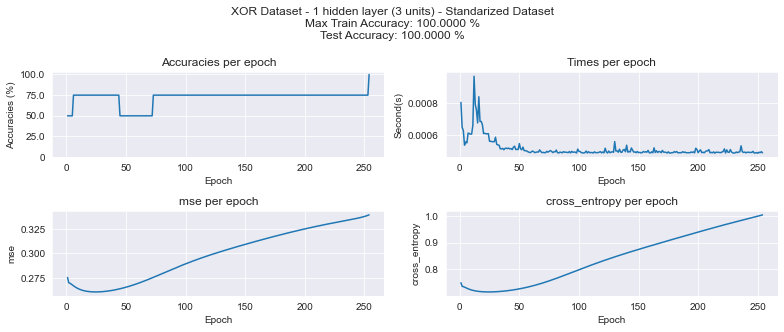

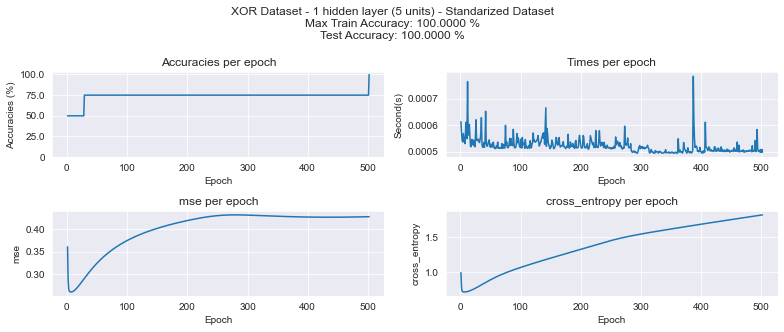

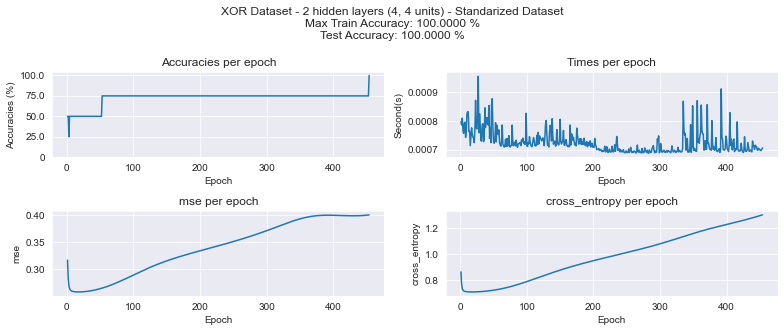

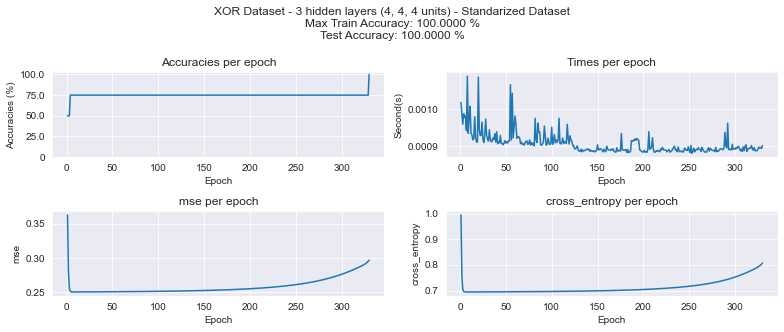

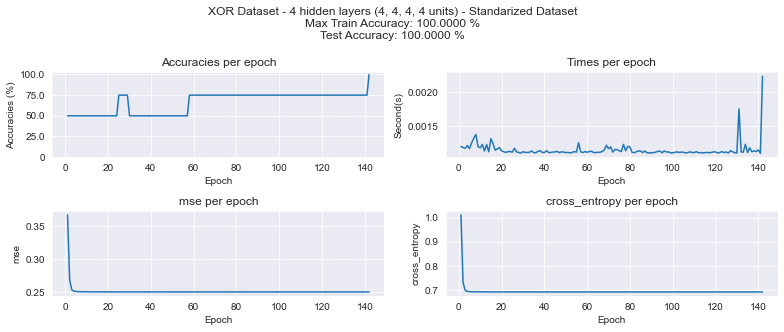

In [ ]:
debug = {'ff': False, 'metrics': False}
subsample = 1

# Plot different the configurations
name = "3__sigmoid_softmax__standarized"
title = "XOR Dataset - 1 hidden layer (3 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "5__sigmoid_softmax__standarized"
title = "XOR Dataset - 1 hidden layer (5 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4__sigmoid_softmax__standarized"
title = "XOR Dataset - 2 hidden layers (4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4_4__sigmoid_softmax__standarized"
title = "XOR Dataset - 3 hidden layers (4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4_4_4__sigmoid_softmax__standarized"
title = "XOR Dataset - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)


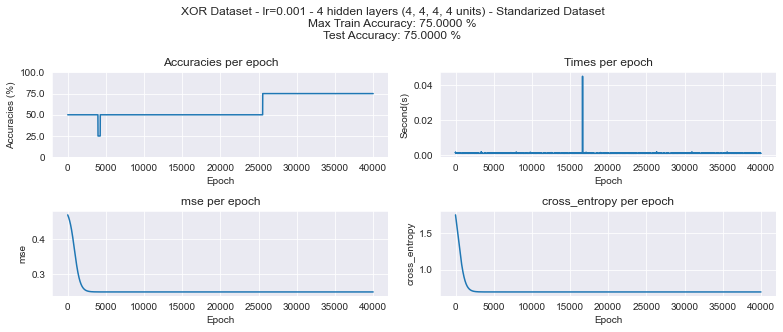

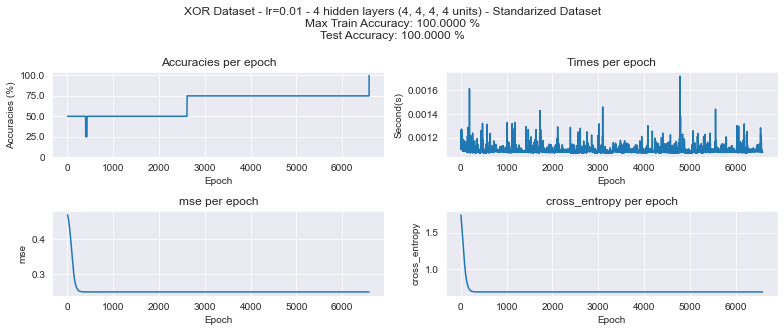

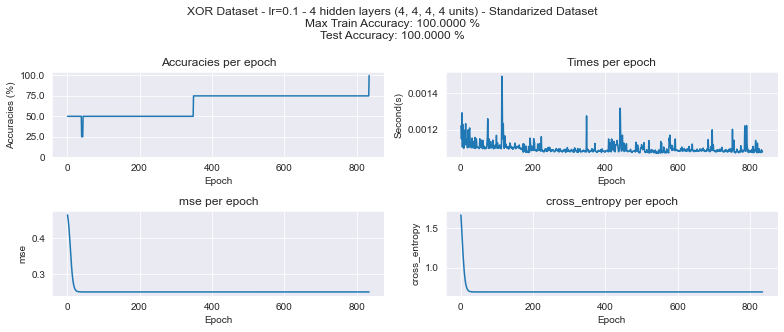

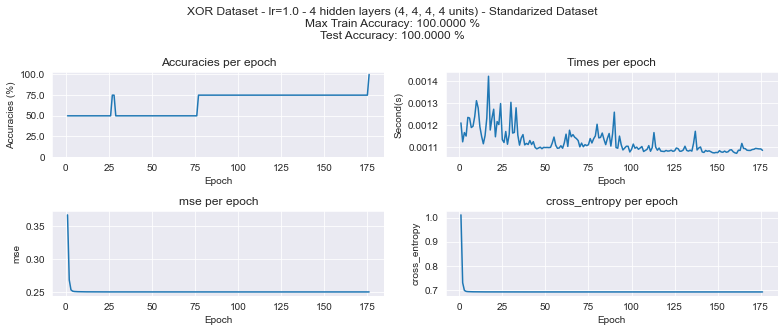

In [ ]:
# Plot different the configurations
name = "4_4_4_4__sigmoid_softmax__standarized__lr_0.001"
title = "XOR Dataset - lr=0.001 - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4_4_4__sigmoid_softmax__standarized__lr_0.01"
title = "XOR Dataset - lr=0.01 - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4_4_4__sigmoid_softmax__standarized__lr_0.1"
title = "XOR Dataset - lr=0.1 - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4_4_4__sigmoid_softmax__standarized__lr_1.0"
title = "XOR Dataset - lr=1.0 - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

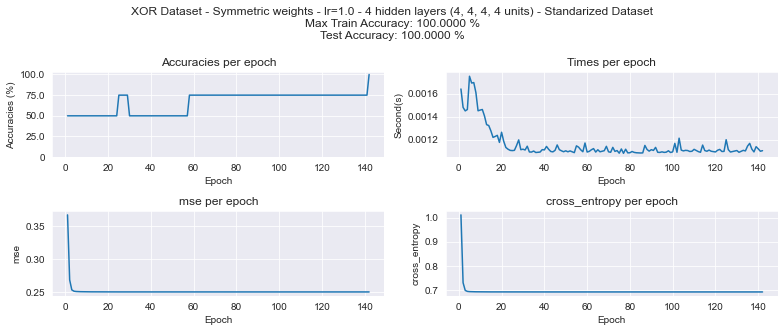

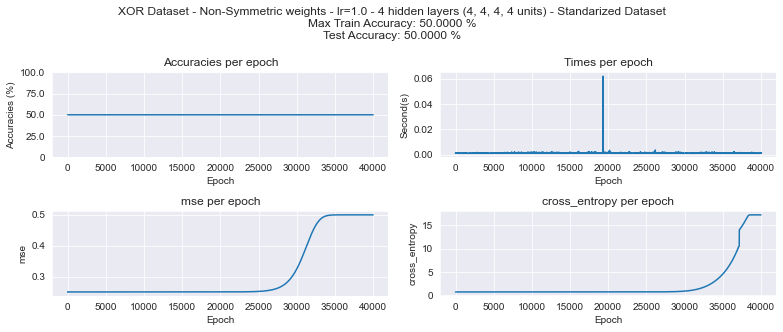

In [ ]:
# Plot different the configurations
name = "4_4_4_4__sigmoid_softmax__standarized__lr_1.0_symmetric"
title = "XOR Dataset - Symmetric weights - lr=1.0 - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

name = "4_4_4_4__sigmoid_softmax__standarized__lr_1.0_non_symmetric"
title = "XOR Dataset - Non-Symmetric weights - lr=1.0 - 4 hidden layers (4, 4, 4, 4 units) - Standarized Dataset"
test_and_plot(title, xor_data_stand, xor_y_one_hot, xor_models[name], xor_accuracies[name], 
              xor_losses[name], xor_times[name], subsample)

## MNIST Dataset

### Training

In [133]:
loss_functions = ['mse', 'cross_entropy']
lr = 1.0
momentum = 0.0
batch_size = 15
max_epochs = 50
regularization_param = 0.01
symmetric_weights = True
shuffle = True
seed = 3
early_stopping = {"max_accuracy": 0.95, 'wait': 2}
debug = {'epochs': 1, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}

mnist_models = {}
mnist_accuracies = {}
mnist_losses = {}
mnist_times = {}

#### Nielsen's setup - Different Model Structures

In [134]:
# -- Experiment with diffent layers - units

### 1 Hidden layers - 30 units
# Standarized Dataset
hidden_layers = [32]
activations = ["sigmoid", "sigmoid"]
name = "32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### 1 Hidden layer - 64 units
## Standarized Dataset
hidden_layers = [64]
activations = ["sigmoid", "sigmoid"]
name = "64__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)


### 1 Hidden layer - 128 units
## Standarized Dataset
hidden_layers = [128]
activations = ["sigmoid", "sigmoid"]
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### 2 Hidden layers - 32, 32 units
## Standarized Dataset
hidden_layers = [32, 32]
activations = ["sigmoid", "sigmoid", "sigmoid"]
name = "32_32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)



### 3 Hidden layers - 16, 16, 16 units
## Standarized Dataset
hidden_layers = [16, 16, 16]
activations = ["sigmoid", "sigmoid", "sigmoid", "sigmoid"]
name = "16_16_16__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

2021-10-30 23:46:03 Project4 Models INFO     Epoch: 1
2021-10-30 23:47:52 Project4 Models INFO       mse Loss: 0.00033
2021-10-30 23:47:52 Project4 Models INFO       cross_entropy Loss: 0.00116
2021-10-30 23:47:52 Project4 Models INFO       Accuracy: 45628/50000
2021-10-30 23:47:52 Project4 Models INFO     Epoch: 2
2021-10-30 23:49:04 Project4 Models INFO       mse Loss: 0.00031
2021-10-30 23:49:04 Project4 Models INFO       cross_entropy Loss: 0.00114
2021-10-30 23:49:04 Project4 Models INFO       Accuracy: 46198/50000
2021-10-30 23:49:04 Project4 Models INFO     Epoch: 3
2021-10-30 23:50:18 Project4 Models INFO       mse Loss: 0.00031
2021-10-30 23:50:18 Project4 Models INFO       cross_entropy Loss: 0.00115
2021-10-30 23:50:18 Project4 Models INFO       Accuracy: 46450/50000
2021-10-30 23:50:18 Project4 Models INFO     Epoch: 4
2021-10-30 23:51:21 Project4 Models INFO       mse Loss: 0.00031
2021-10-30 23:51:21 Project4 Models INFO       cross_entropy Loss: 0.00115
2021-10-30 23:51:

2021-10-31 00:26:49 Project4 Models INFO     Epoch: 27
2021-10-31 00:28:36 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 00:28:36 Project4 Models INFO       cross_entropy Loss: 0.00115
2021-10-31 00:28:36 Project4 Models INFO       Accuracy: 46608/50000
2021-10-31 00:28:36 Project4 Models INFO     Epoch: 28
2021-10-31 00:30:16 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 00:30:16 Project4 Models INFO       cross_entropy Loss: 0.00116
2021-10-31 00:30:16 Project4 Models INFO       Accuracy: 46524/50000
2021-10-31 00:30:16 Project4 Models INFO     Epoch: 29
2021-10-31 00:32:00 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 00:32:00 Project4 Models INFO       cross_entropy Loss: 0.00115
2021-10-31 00:32:00 Project4 Models INFO       Accuracy: 46534/50000
2021-10-31 00:32:00 Project4 Models INFO     Epoch: 30
2021-10-31 00:33:44 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 00:33:44 Project4 Models INFO       cross_entropy Loss: 0.00115
2021-10-31 00

2021-10-31 01:11:50 Project4 Models INFO       cross_entropy Loss: 0.00129
2021-10-31 01:11:50 Project4 Models INFO       Accuracy: 45636/50000
2021-10-31 01:11:50 Project4 Models INFO     Epoch: 2
2021-10-31 01:13:58 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 01:13:58 Project4 Models INFO       cross_entropy Loss: 0.00125
2021-10-31 01:13:58 Project4 Models INFO       Accuracy: 46231/50000
2021-10-31 01:13:58 Project4 Models INFO     Epoch: 3
2021-10-31 01:16:07 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 01:16:07 Project4 Models INFO       cross_entropy Loss: 0.00126
2021-10-31 01:16:07 Project4 Models INFO       Accuracy: 46336/50000
2021-10-31 01:16:07 Project4 Models INFO     Epoch: 4
2021-10-31 01:18:11 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 01:18:11 Project4 Models INFO       cross_entropy Loss: 0.00125
2021-10-31 01:18:11 Project4 Models INFO       Accuracy: 46663/50000
2021-10-31 01:18:11 Project4 Models INFO     Epoch: 5
2021-10-31 01

2021-10-31 02:06:56 Project4 Models INFO       cross_entropy Loss: 0.00124
2021-10-31 02:06:56 Project4 Models INFO       Accuracy: 46903/50000
2021-10-31 02:06:56 Project4 Models INFO     Epoch: 28
2021-10-31 02:08:58 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 02:08:58 Project4 Models INFO       cross_entropy Loss: 0.00125
2021-10-31 02:08:58 Project4 Models INFO       Accuracy: 46872/50000
2021-10-31 02:08:58 Project4 Models INFO     Epoch: 29
2021-10-31 02:11:02 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 02:11:02 Project4 Models INFO       cross_entropy Loss: 0.00125
2021-10-31 02:11:02 Project4 Models INFO       Accuracy: 46968/50000
2021-10-31 02:11:02 Project4 Models INFO     Epoch: 30
2021-10-31 02:12:59 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 02:12:59 Project4 Models INFO       cross_entropy Loss: 0.00125
2021-10-31 02:12:59 Project4 Models INFO       Accuracy: 46887/50000
2021-10-31 02:12:59 Project4 Models INFO     Epoch: 31
2021-10-3

2021-10-31 02:52:56 Project4 Models INFO     Epoch: 2
2021-10-31 02:55:04 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 02:55:04 Project4 Models INFO       cross_entropy Loss: 0.00138
2021-10-31 02:55:04 Project4 Models INFO       Accuracy: 45779/50000
2021-10-31 02:55:04 Project4 Models INFO     Epoch: 3
2021-10-31 02:57:25 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 02:57:25 Project4 Models INFO       cross_entropy Loss: 0.00134
2021-10-31 02:57:25 Project4 Models INFO       Accuracy: 46302/50000
2021-10-31 02:57:25 Project4 Models INFO     Epoch: 4
2021-10-31 02:59:50 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 02:59:50 Project4 Models INFO       cross_entropy Loss: 0.00136
2021-10-31 02:59:50 Project4 Models INFO       Accuracy: 46622/50000
2021-10-31 02:59:50 Project4 Models INFO     Epoch: 5
2021-10-31 03:02:08 Project4 Models INFO       mse Loss: 0.00033
2021-10-31 03:02:08 Project4 Models INFO       cross_entropy Loss: 0.00137
2021-10-31 03:02:

2021-10-31 03:59:10 Project4 Models INFO     Epoch: 28
2021-10-31 04:01:37 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 04:01:37 Project4 Models INFO       cross_entropy Loss: 0.00134
2021-10-31 04:01:37 Project4 Models INFO       Accuracy: 46777/50000
2021-10-31 04:01:37 Project4 Models INFO     Epoch: 29
2021-10-31 04:03:34 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 04:03:34 Project4 Models INFO       cross_entropy Loss: 0.00132
2021-10-31 04:03:34 Project4 Models INFO       Accuracy: 46804/50000
2021-10-31 04:03:34 Project4 Models INFO     Epoch: 30
2021-10-31 04:05:15 Project4 Models INFO       mse Loss: 0.00033
2021-10-31 04:05:15 Project4 Models INFO       cross_entropy Loss: 0.00134
2021-10-31 04:05:15 Project4 Models INFO       Accuracy: 46959/50000
2021-10-31 04:05:15 Project4 Models INFO     Epoch: 31
2021-10-31 04:07:07 Project4 Models INFO       mse Loss: 0.00033
2021-10-31 04:07:07 Project4 Models INFO       cross_entropy Loss: 0.00134
2021-10-31 04

2021-10-31 04:45:06 Project4 Models INFO       cross_entropy Loss: 0.00104
2021-10-31 04:45:06 Project4 Models INFO       Accuracy: 45894/50000
2021-10-31 04:45:06 Project4 Models INFO     Epoch: 3
2021-10-31 04:46:27 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 04:46:27 Project4 Models INFO       cross_entropy Loss: 0.00104
2021-10-31 04:46:27 Project4 Models INFO       Accuracy: 45944/50000
2021-10-31 04:46:27 Project4 Models INFO     Epoch: 4
2021-10-31 04:47:54 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 04:47:54 Project4 Models INFO       cross_entropy Loss: 0.00105
2021-10-31 04:47:54 Project4 Models INFO       Accuracy: 46000/50000
2021-10-31 04:47:54 Project4 Models INFO     Epoch: 5
2021-10-31 04:49:27 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 04:49:27 Project4 Models INFO       cross_entropy Loss: 0.00106
2021-10-31 04:49:27 Project4 Models INFO       Accuracy: 46117/50000
2021-10-31 04:49:27 Project4 Models INFO     Epoch: 6
2021-10-31 04

2021-10-31 05:22:19 Project4 Models INFO       cross_entropy Loss: 0.00109
2021-10-31 05:22:19 Project4 Models INFO       Accuracy: 46186/50000
2021-10-31 05:22:19 Project4 Models INFO     Epoch: 29
2021-10-31 05:23:40 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 05:23:40 Project4 Models INFO       cross_entropy Loss: 0.00109
2021-10-31 05:23:40 Project4 Models INFO       Accuracy: 46224/50000
2021-10-31 05:23:40 Project4 Models INFO     Epoch: 30
2021-10-31 05:25:03 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 05:25:03 Project4 Models INFO       cross_entropy Loss: 0.00108
2021-10-31 05:25:03 Project4 Models INFO       Accuracy: 46148/50000
2021-10-31 05:25:03 Project4 Models INFO     Epoch: 31
2021-10-31 05:26:35 Project4 Models INFO       mse Loss: 0.00032
2021-10-31 05:26:35 Project4 Models INFO       cross_entropy Loss: 0.00110
2021-10-31 05:26:35 Project4 Models INFO       Accuracy: 46115/50000
2021-10-31 05:26:35 Project4 Models INFO     Epoch: 32
2021-10-3

2021-10-31 05:56:02 Project4 Models INFO     Epoch: 3
2021-10-31 05:57:28 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 05:57:28 Project4 Models INFO       cross_entropy Loss: 0.00102
2021-10-31 05:57:28 Project4 Models INFO       Accuracy: 44291/50000
2021-10-31 05:57:28 Project4 Models INFO     Epoch: 4
2021-10-31 05:58:37 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 05:58:37 Project4 Models INFO       cross_entropy Loss: 0.00103
2021-10-31 05:58:37 Project4 Models INFO       Accuracy: 44417/50000
2021-10-31 05:58:37 Project4 Models INFO     Epoch: 5
2021-10-31 05:59:58 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 05:59:58 Project4 Models INFO       cross_entropy Loss: 0.00103
2021-10-31 05:59:58 Project4 Models INFO       Accuracy: 44461/50000
2021-10-31 05:59:58 Project4 Models INFO     Epoch: 6
2021-10-31 06:01:06 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 06:01:06 Project4 Models INFO       cross_entropy Loss: 0.00104
2021-10-31 06:01:

2021-10-31 06:27:54 Project4 Models INFO     Epoch: 29
2021-10-31 06:29:01 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 06:29:01 Project4 Models INFO       cross_entropy Loss: 0.00104
2021-10-31 06:29:01 Project4 Models INFO       Accuracy: 45283/50000
2021-10-31 06:29:01 Project4 Models INFO     Epoch: 30
2021-10-31 06:30:17 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 06:30:17 Project4 Models INFO       cross_entropy Loss: 0.00104
2021-10-31 06:30:17 Project4 Models INFO       Accuracy: 44533/50000
2021-10-31 06:30:17 Project4 Models INFO     Epoch: 31
2021-10-31 06:31:25 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 06:31:25 Project4 Models INFO       cross_entropy Loss: 0.00103
2021-10-31 06:31:25 Project4 Models INFO       Accuracy: 45204/50000
2021-10-31 06:31:25 Project4 Models INFO     Epoch: 32
2021-10-31 06:32:41 Project4 Models INFO       mse Loss: 0.00031
2021-10-31 06:32:41 Project4 Models INFO       cross_entropy Loss: 0.00104
2021-10-31 06

#### Nielsen's setup - Different Mini-Batch Size

In [152]:
# -- Experiment with diffent layers - units
hidden_layers = [128]
activations = ["sigmoid", "sigmoid"]


### Mini-batch 25
batch_size = 25
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_25"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### Mini-batch 50
batch_size = 50
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_50"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### Mini-batch 100
batch_size = 100
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_100"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

2021-10-31 14:56:52 Project4 Models INFO     Epoch: 1
2021-10-31 14:59:12 Project4 Models INFO       mse Loss: 0.00702
2021-10-31 14:59:12 Project4 Models INFO       cross_entropy Loss: 0.00933
2021-10-31 14:59:12 Project4 Models INFO       Accuracy: 22965/50000
2021-10-31 14:59:12 Project4 Models INFO     Epoch: 2
2021-10-31 15:01:34 Project4 Models INFO       mse Loss: 0.00481
2021-10-31 15:01:34 Project4 Models INFO       cross_entropy Loss: 0.00672
2021-10-31 15:01:34 Project4 Models INFO       Accuracy: 31254/50000
2021-10-31 15:01:34 Project4 Models INFO     Epoch: 3
2021-10-31 15:03:53 Project4 Models INFO       mse Loss: 0.00334
2021-10-31 15:03:53 Project4 Models INFO       cross_entropy Loss: 0.00503
2021-10-31 15:03:53 Project4 Models INFO       Accuracy: 39236/50000
2021-10-31 15:03:53 Project4 Models INFO     Epoch: 4
2021-10-31 15:06:18 Project4 Models INFO       mse Loss: 0.00234
2021-10-31 15:06:18 Project4 Models INFO       cross_entropy Loss: 0.00382
2021-10-31 15:06:

In [136]:
# name = "32_32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
# mnist_accuracies[name] = [a-0.18 for a in  mnist_accuracies[name]]
# print( mnist_accuracies[name])

In [137]:
max_epochs = 50
batch_size = 25

# -- Experiment with diffent layers - units
hidden_layers = [128]
activations = ["sigmoid", "sigmoid"]
batch_size=50

### lr = 0.001
lr = 0.001
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_0.001__batch_25"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### lr = 0.01
lr = 0.01
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_0.01__batch_25"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

### lr = 0.1
lr = 0.1
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_0.1__batch_25"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

# ### lr = 1.0
lr = 1.0
## Standarized Dataset
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_25"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)

2021-10-31 08:12:57 Project4 Models INFO     Epoch: 1
2021-10-31 08:14:45 Project4 Models INFO       mse Loss: 0.01092
2021-10-31 08:14:45 Project4 Models INFO       cross_entropy Loss: 0.01685
2021-10-31 08:14:45 Project4 Models INFO       Accuracy: 6740/50000
2021-10-31 08:14:45 Project4 Models INFO     Epoch: 2
2021-10-31 08:16:25 Project4 Models INFO       mse Loss: 0.01087
2021-10-31 08:16:25 Project4 Models INFO       cross_entropy Loss: 0.01646
2021-10-31 08:16:25 Project4 Models INFO       Accuracy: 6691/50000
2021-10-31 08:16:25 Project4 Models INFO     Epoch: 3
2021-10-31 08:18:14 Project4 Models INFO       mse Loss: 0.01083
2021-10-31 08:18:14 Project4 Models INFO       cross_entropy Loss: 0.01608
2021-10-31 08:18:14 Project4 Models INFO       Accuracy: 6627/50000
2021-10-31 08:18:14 Project4 Models INFO     Epoch: 4
2021-10-31 08:20:05 Project4 Models INFO       mse Loss: 0.01079
2021-10-31 08:20:05 Project4 Models INFO       cross_entropy Loss: 0.01573
2021-10-31 08:20:05 

2021-10-31 09:02:40 Project4 Models INFO       mse Loss: 0.01026
2021-10-31 09:02:40 Project4 Models INFO       cross_entropy Loss: 0.01230
2021-10-31 09:02:40 Project4 Models INFO       Accuracy: 8966/50000
2021-10-31 09:02:40 Project4 Models INFO     Epoch: 28
2021-10-31 09:04:37 Project4 Models INFO       mse Loss: 0.01025
2021-10-31 09:04:37 Project4 Models INFO       cross_entropy Loss: 0.01227
2021-10-31 09:04:37 Project4 Models INFO       Accuracy: 9153/50000
2021-10-31 09:04:37 Project4 Models INFO     Epoch: 29
2021-10-31 09:06:31 Project4 Models INFO       mse Loss: 0.01024
2021-10-31 09:06:31 Project4 Models INFO       cross_entropy Loss: 0.01225
2021-10-31 09:06:31 Project4 Models INFO       Accuracy: 9316/50000
2021-10-31 09:06:31 Project4 Models INFO     Epoch: 30
2021-10-31 09:08:23 Project4 Models INFO       mse Loss: 0.01023
2021-10-31 09:08:23 Project4 Models INFO       cross_entropy Loss: 0.01223
2021-10-31 09:08:23 Project4 Models INFO       Accuracy: 9487/50000
202

2021-10-31 09:47:32 Project4 Models INFO       Accuracy: 6028/50000
2021-10-31 09:47:32 Project4 Models INFO     Epoch: 2
2021-10-31 09:49:28 Project4 Models INFO       mse Loss: 0.01037
2021-10-31 09:49:28 Project4 Models INFO       cross_entropy Loss: 0.01286
2021-10-31 09:49:28 Project4 Models INFO       Accuracy: 6599/50000
2021-10-31 09:49:28 Project4 Models INFO     Epoch: 3
2021-10-31 09:51:26 Project4 Models INFO       mse Loss: 0.01023
2021-10-31 09:51:26 Project4 Models INFO       cross_entropy Loss: 0.01223
2021-10-31 09:51:26 Project4 Models INFO       Accuracy: 9464/50000
2021-10-31 09:51:26 Project4 Models INFO     Epoch: 4
2021-10-31 09:53:19 Project4 Models INFO       mse Loss: 0.01016
2021-10-31 09:53:19 Project4 Models INFO       cross_entropy Loss: 0.01221
2021-10-31 09:53:19 Project4 Models INFO       Accuracy: 10536/50000
2021-10-31 09:53:19 Project4 Models INFO     Epoch: 5
2021-10-31 09:55:10 Project4 Models INFO       mse Loss: 0.01012
2021-10-31 09:55:10 Projec

2021-10-31 10:36:36 Project4 Models INFO       Accuracy: 15682/50000
2021-10-31 10:36:36 Project4 Models INFO     Epoch: 28
2021-10-31 10:38:33 Project4 Models INFO       mse Loss: 0.00925
2021-10-31 10:38:33 Project4 Models INFO       cross_entropy Loss: 0.01168
2021-10-31 10:38:33 Project4 Models INFO       Accuracy: 15820/50000
2021-10-31 10:38:33 Project4 Models INFO     Epoch: 29
2021-10-31 10:40:27 Project4 Models INFO       mse Loss: 0.00922
2021-10-31 10:40:27 Project4 Models INFO       cross_entropy Loss: 0.01164
2021-10-31 10:40:27 Project4 Models INFO       Accuracy: 15962/50000
2021-10-31 10:40:27 Project4 Models INFO     Epoch: 30
2021-10-31 10:42:19 Project4 Models INFO       mse Loss: 0.00918
2021-10-31 10:42:19 Project4 Models INFO       cross_entropy Loss: 0.01160
2021-10-31 10:42:19 Project4 Models INFO       Accuracy: 16135/50000
2021-10-31 10:42:19 Project4 Models INFO     Epoch: 31
2021-10-31 10:44:02 Project4 Models INFO       mse Loss: 0.00915
2021-10-31 10:44:02

2021-10-31 11:23:03 Project4 Models INFO       mse Loss: 0.00954
2021-10-31 11:23:03 Project4 Models INFO       cross_entropy Loss: 0.01196
2021-10-31 11:23:03 Project4 Models INFO       Accuracy: 14606/50000
2021-10-31 11:23:03 Project4 Models INFO     Epoch: 3
2021-10-31 11:24:58 Project4 Models INFO       mse Loss: 0.00918
2021-10-31 11:24:58 Project4 Models INFO       cross_entropy Loss: 0.01161
2021-10-31 11:24:58 Project4 Models INFO       Accuracy: 16077/50000
2021-10-31 11:24:58 Project4 Models INFO     Epoch: 4
2021-10-31 11:26:57 Project4 Models INFO       mse Loss: 0.00884
2021-10-31 11:26:57 Project4 Models INFO       cross_entropy Loss: 0.01125
2021-10-31 11:26:57 Project4 Models INFO       Accuracy: 17587/50000
2021-10-31 11:26:57 Project4 Models INFO     Epoch: 5
2021-10-31 11:28:52 Project4 Models INFO       mse Loss: 0.00850
2021-10-31 11:28:52 Project4 Models INFO       cross_entropy Loss: 0.01091
2021-10-31 11:28:52 Project4 Models INFO       Accuracy: 18753/50000
20

2021-10-31 12:11:44 Project4 Models INFO       mse Loss: 0.00359
2021-10-31 12:11:44 Project4 Models INFO       cross_entropy Loss: 0.00530
2021-10-31 12:11:44 Project4 Models INFO       Accuracy: 39043/50000
2021-10-31 12:11:44 Project4 Models INFO     Epoch: 29
2021-10-31 12:13:35 Project4 Models INFO       mse Loss: 0.00346
2021-10-31 12:13:35 Project4 Models INFO       cross_entropy Loss: 0.00515
2021-10-31 12:13:35 Project4 Models INFO       Accuracy: 39267/50000
2021-10-31 12:13:35 Project4 Models INFO     Epoch: 30
2021-10-31 12:15:24 Project4 Models INFO       mse Loss: 0.00334
2021-10-31 12:15:24 Project4 Models INFO       cross_entropy Loss: 0.00501
2021-10-31 12:15:24 Project4 Models INFO       Accuracy: 39459/50000
2021-10-31 12:15:24 Project4 Models INFO     Epoch: 31
2021-10-31 12:17:13 Project4 Models INFO       mse Loss: 0.00322
2021-10-31 12:17:13 Project4 Models INFO       cross_entropy Loss: 0.00486
2021-10-31 12:17:13 Project4 Models INFO       Accuracy: 39626/50000

2021-10-31 12:56:44 Project4 Models INFO       Accuracy: 31254/50000
2021-10-31 12:56:44 Project4 Models INFO     Epoch: 3
2021-10-31 12:58:44 Project4 Models INFO       mse Loss: 0.00334
2021-10-31 12:58:44 Project4 Models INFO       cross_entropy Loss: 0.00503
2021-10-31 12:58:44 Project4 Models INFO       Accuracy: 39236/50000
2021-10-31 12:58:44 Project4 Models INFO     Epoch: 4
2021-10-31 13:00:35 Project4 Models INFO       mse Loss: 0.00234
2021-10-31 13:00:35 Project4 Models INFO       cross_entropy Loss: 0.00382
2021-10-31 13:00:35 Project4 Models INFO       Accuracy: 40693/50000
2021-10-31 13:00:35 Project4 Models INFO     Epoch: 5
2021-10-31 13:02:24 Project4 Models INFO       mse Loss: 0.00168
2021-10-31 13:02:24 Project4 Models INFO       cross_entropy Loss: 0.00305
2021-10-31 13:02:24 Project4 Models INFO       Accuracy: 45398/50000
2021-10-31 13:02:24 Project4 Models INFO     Epoch: 6
2021-10-31 13:04:11 Project4 Models INFO       mse Loss: 0.00124
2021-10-31 13:04:11 Pro

### Testing

In [142]:
subsample = 1

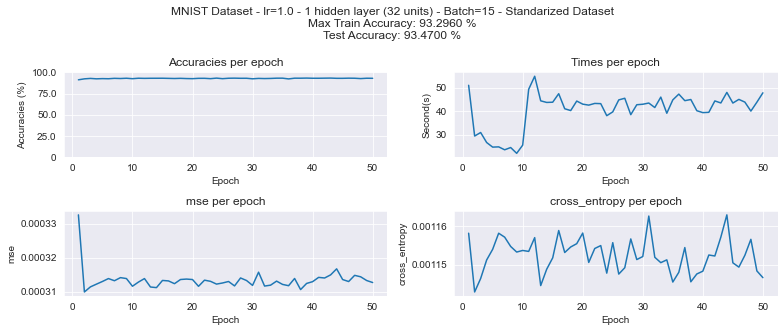

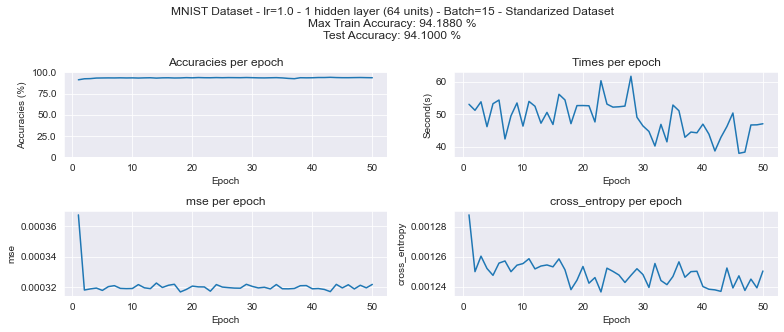

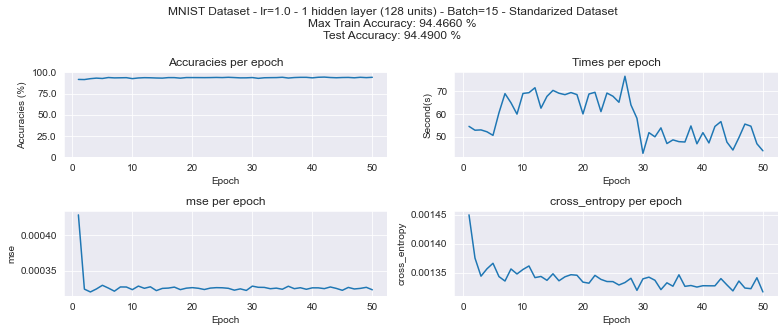

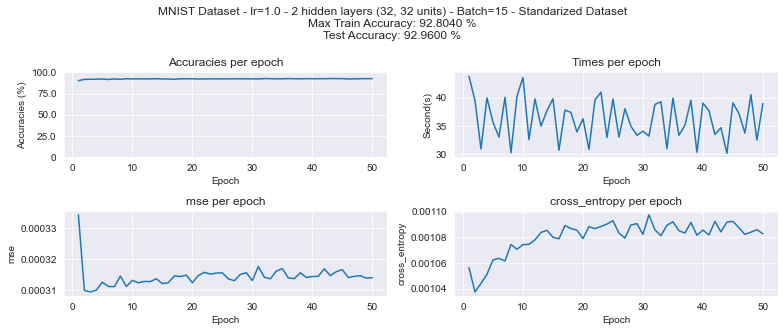

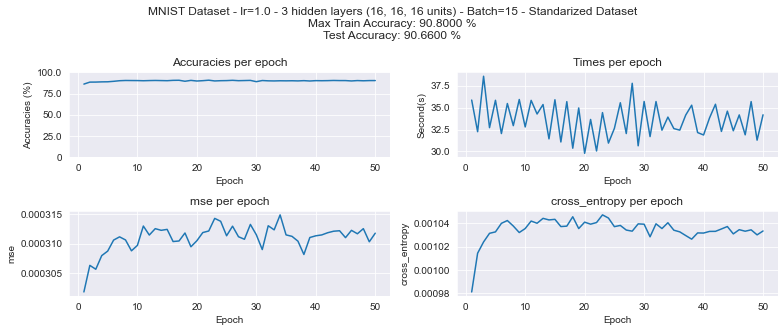

In [162]:
# Plot different the configurations for different Network Structures
name = "32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (32 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "64__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (64 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "32_32__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 2 hidden layers (32, 32 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "16_16_16__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 3 hidden layers (16, 16, 16 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

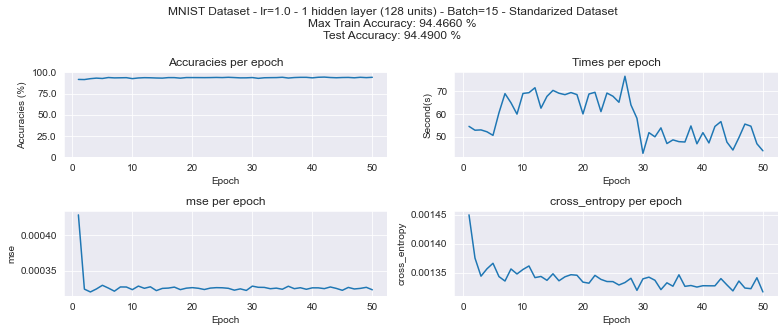

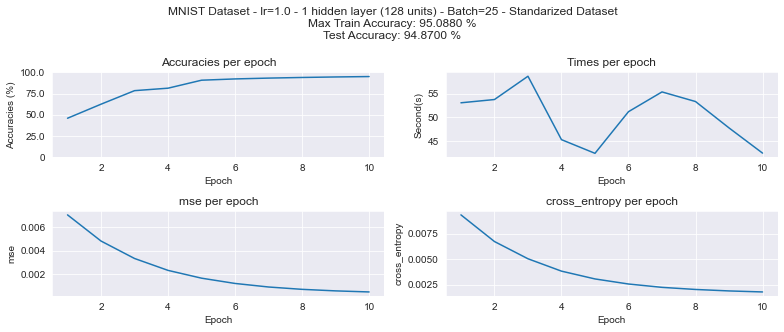

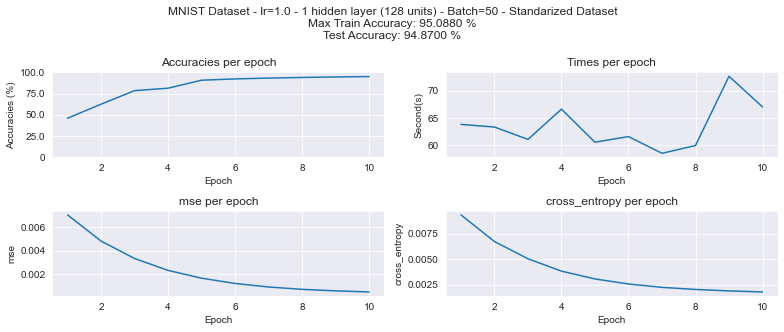

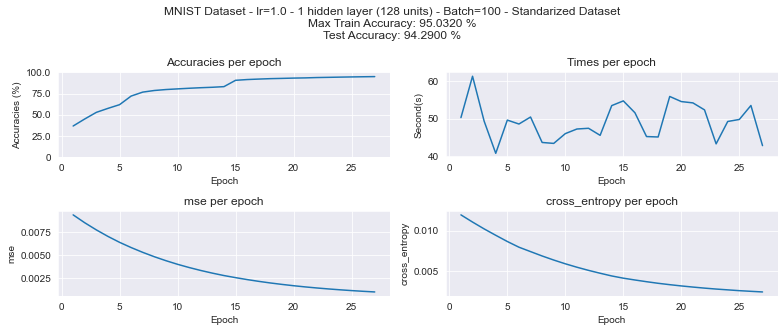

In [154]:
# Plot different the configurations for different Batch sizes
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_15"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=15 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_25"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=25 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_50"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=50 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_100"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=100 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

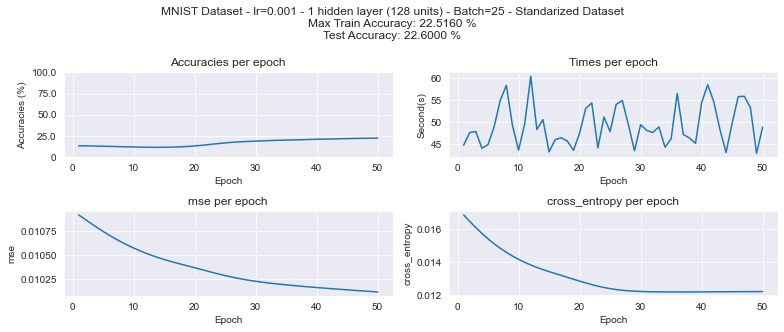

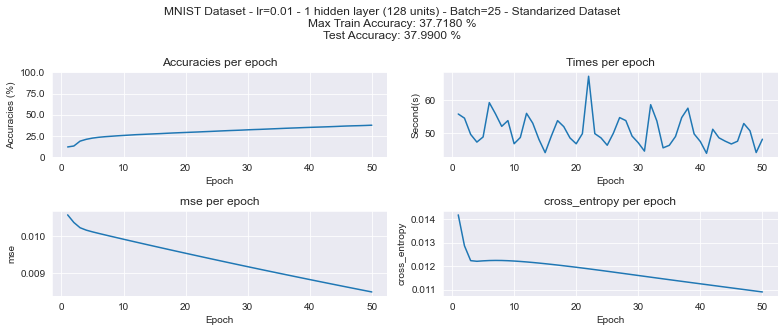

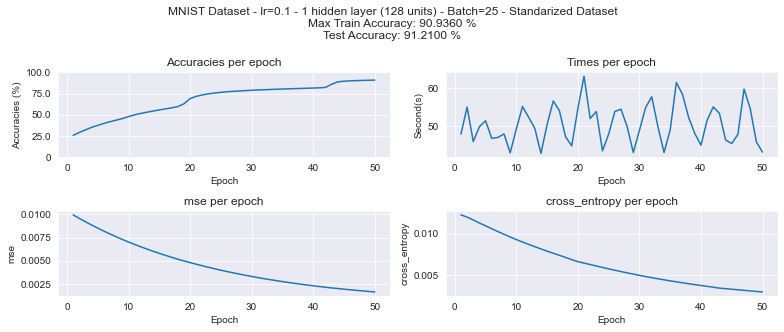

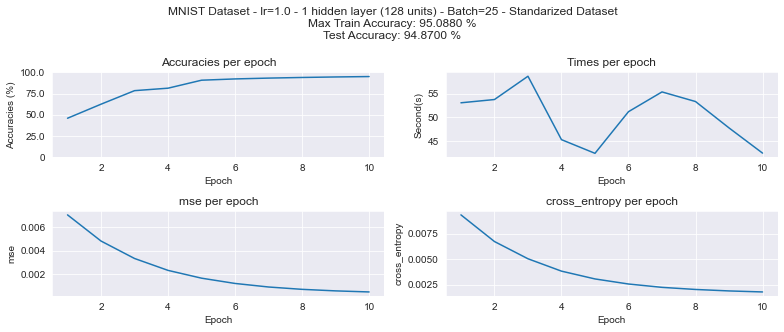

In [148]:
# Plot different the configurations for different Learning Rates
name = "128__sigmoid_sigmoid__standarized__lr_0.001__batch_25"
title = "MNIST Dataset - lr=0.001 - 1 hidden layer (128 units) - Batch=25 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_0.01__batch_25"
title = "MNIST Dataset - lr=0.01 - 1 hidden layer (128 units) - Batch=25 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_0.1__batch_25"
title = "MNIST Dataset - lr=0.1 - 1 hidden layer (128 units) - Batch=25 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_25"
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=25 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)

## Best Configuration

In [163]:
loss_functions = ['mse', 'cross_entropy']
lr = 1.0
hidden_layers = [128]
activations = ["sigmoid", "sigmoid"]
batch_size= 50
momentum = 0.0001
batch_size = 50
max_epochs = 50
regularization_param = 0.01
symmetric_weights = True
shuffle = True
seed = 3
early_stopping = {"max_accuracy": 0.99, 'wait': 2}
debug = {'epochs': 1, 'batches': 10**10, 
         'ff': False, 'bp': False, 'w': False, 'metrics': False}

In [164]:
name = "128__sigmoid_sigmoid__standarized__lr_1.0__batch_50__momemntum_0.0001"
mnist_models[name], mnist_accuracies[name], mnist_losses[name], mnist_times[name] = \
train_dataset(mnist_tr_stand.copy(), mnist_tr_y_one_hot.copy(), hidden_layers, activations, 
              loss_functions, lr, momentum, batch_size, early_stopping,
              max_epochs, regularization_param, shuffle, symmetric_weights, seed, debug)


2021-10-31 16:33:27 Project4 Models INFO     Epoch: 1
2021-10-31 16:35:27 Project4 Models INFO       mse Loss: 0.00851
2021-10-31 16:35:27 Project4 Models INFO       cross_entropy Loss: 0.01109
2021-10-31 16:35:27 Project4 Models INFO       Accuracy: 22103/50000
2021-10-31 16:35:27 Project4 Models INFO     Epoch: 2
2021-10-31 16:37:18 Project4 Models INFO       mse Loss: 0.00704
2021-10-31 16:37:18 Project4 Models INFO       cross_entropy Loss: 0.00944
2021-10-31 16:37:18 Project4 Models INFO       Accuracy: 28427/50000
2021-10-31 16:37:18 Project4 Models INFO     Epoch: 3
2021-10-31 16:39:08 Project4 Models INFO       mse Loss: 0.00583
2021-10-31 16:39:08 Project4 Models INFO       cross_entropy Loss: 0.00800
2021-10-31 16:39:08 Project4 Models INFO       Accuracy: 34218/50000
2021-10-31 16:39:08 Project4 Models INFO     Epoch: 4
2021-10-31 16:41:17 Project4 Models INFO       mse Loss: 0.00484
2021-10-31 16:41:17 Project4 Models INFO       cross_entropy Loss: 0.00690
2021-10-31 16:41:

ValueError: x and y must have same first dimension, but have shapes (8,) and (9,)

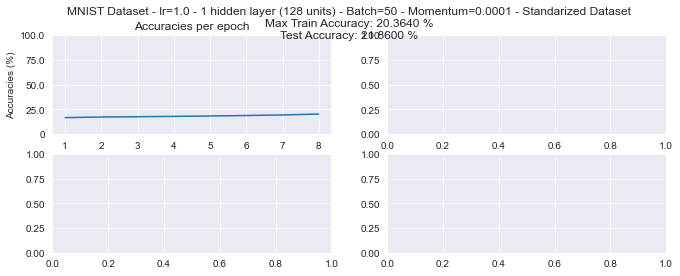

In [157]:
title = "MNIST Dataset - lr=1.0 - 1 hidden layer (128 units) - Batch=50 - Momentum=0.0001 - Standarized Dataset"
test_and_plot(title, mnist_te_stand, mnist_te_y_one_hot, mnist_models[name], mnist_accuracies[name], 
              mnist_losses[name], mnist_times[name], subsample)